In [1]:
import logging
import os
from pathlib import Path 
from typing import Dict, List 
import json
from omegaconf import OmegaConf,DictConfig
from hydra.core.hydra_config import HydraConfig
import pandas as pd 

from quvine.data.data_loader import load_graph, load_gwas_data
from quvine.data.preprocess import build_subgraph, sparsify_graph
from quvine.views.generator import ViewBuilder
from quvine.walks.base import BaseWalker
from quvine.corpus.builder import CorpusBuilder
from quvine.embedding.word2vec import corpus_to_embedding
from quvine.embedding.registry import EmbeddingStore
from quvine.analysis.compare import compare_embeddings
from quvine.analysis.analyze import *
from quvine.baselines import run_node2vec
from quvine.fusion.fuse import fuse_embeddings
from quvine.fusion.diagnostics import analyze_fusion
from quvine.evaluation.ranking import (
    seed_centroid_scores,
    max_seed_cosine_scores,
    evaluate_embeddings_ranking
    )   
#from quvine.evals.ranking import evaluate_ranking
# from utils.io import save_embeddings, save_metadata 
from quvine.utils.seed import set_global_seed
from quvine.utils.utilities import *

In [2]:
path = '/dccstor/boseukb/Q/NetMed/Aug21/GWAS_NetworkPropagation/processed_data/networks/'
network_files = {
    "BioPlex3": path+"BioPlex3_shared/edges_list_ncbi.csv",
    "HumanNet": path+"HumanNetV3/edges_list_ncbi.csv",
    "PCNet": path+"PCNet/edges_list_ncbi.csv",
    "ProteomeHD": path+"ProteomeHD/edges_list_ncbi.csv",
    "STRING": path+"STRING/edges_list_ncbi.csv",
}

networks = ['ProteomeHD','BioPlex3','STRING','HumanNet','PCNet']
diseases = ['asthma','autism','schizophrenia']

In [31]:
from omegaconf import OmegaConf

cfg = OmegaConf.create({
    "data_path": "/dccstor/boseukb/Q/NetMed/Aug21/GWAS_NetworkPropagation/processed_data",

    "graph": {
        "name": "BioPlex3",
        "path": "../Aug21/GWAS_NetworkPropagation/processed_data/networks/BioPlex3_shared/edges_list_ncbi.csv",
    },

    "disease": {
        "name": "autism",
    },

    "runtime": {
        "name": "qune",
        # originally: ${now:%Y-%m-%d_%H-%M-%S}
        # notebook-safe placeholder
        "run_name": "manual_run",
        "run_dir": "../outputs/",
    },

    "experiment": {
        "iterations": 2,
        "base_seed": 42,
    },

    "seed": 42,

    "draw": {
        "graph": True,
        "verbose": False,
    },

    "preprocess": {
        "subgraph": {
            "enabled": True,
            "num_nodes": 20,
            "max_nodes": 400,
            "max_hops": 4,
        },
        "sparsify": {
            "enabled": True,
            "avg_degree": 25,
            "max_degree": 32,
        },
    },

    "verbose": True,
    "plots": True,

    "views": {
        "num_views": 8,
        "constrained": True,
        "max_degree": 3,
        "max_nodes": 20,
        "max_edges": 40,
        "radius": 4,
    },

    "walks": {
        "kinds": ["rwr", "ctqw", "dtqw"],
        "num_walks": 10,
        "walk_length": 6,
        "restart_prob": 0.15,
        "steps": 20,
        "coin": "grover",
        "max_iter": 1000,
    },

    # --------------------
    # shared hyperparameters
    # --------------------
    "dimension": 64,
    "window": 5,
    "min_count": 1,
    "workers": 8,

    "train": {
        "embedding_dim": 64,
        "window": 5,
        "sg": 1,
        "negative": 10,
        "workers": 8,
        "min_count": 1,
        "epochs": 100,
    },

    "baselines": {
        "node2vec": {
            "enabled": True,
            "dimensions": 64,
            "walk_length": 8,
            "num_walks": 10,
            "p": 1,
            "q": 0.5,
            "window": 5,
            "min_count": 1,
            "workers": 8,
            "seed": 42,
        },
    },

    "fusion": {
        "enabled": True,
        "method": "concatenate",
        "k": 10,
    },

    "analysis": {
        "cca_components": 10,
        "knn_k": 5,
    },

    "eval": {
        "k_values": [20, 40, 80],
        "n_repeats": 20,
        "deg_tol": 0.1,
        "centroid": False, 
        "max_seed": True
    },
})


In [29]:
def load_giant(network):
    """
    Loads the largest connected component (giant component) of a network from a CSV file.

    """
    df = pd.read_csv(network_files[network], dtype={'node1': str, 'node2': str})[["node1", "node2"]]
    graph = nx.from_pandas_edgelist(df, source="node1", target="node2")
    # Find the largest connected component in the graph
    giant = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(giant)
    
    return graph

def get_stats(G): 
    stats = {}
    stats['num_nodes'] = G.number_of_nodes()
    stats['num_edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)
    stats['num_connected_components'] = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len)
    stats['largest_cc_size'] = len(largest_cc)
    stats['average_clustering_coefficient'] = nx.average_clustering(G)
    degrees = [d for n, d in G.degree()]
    stats['average_degree'] = np.mean(degrees)
    stats['degree_assortativity_coefficient'] = nx.degree_assortativity_coefficient(G)
    betweenness = list(nx.betweenness_centrality(G).values())
    stats['average_clustering_coefficient'] = np.mean(betweenness)
    
    return stats

def draw_graph(G, source=None, target=None, title="Graph"):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    default_color = "#185e8d"
    d = dict(G.degree())
    node_colors = [default_color] * len(G.nodes)
    node_to_index = {node:i for i, node in enumerate(G.nodes)}
    if source is None and target is None:
        nx.draw_networkx(G, 
                pos = pos, 
                with_labels=True,
                nodelist=list(d.keys()), 
                node_color=node_colors,
                node_size=[v*6 for v in d.values()],
                width=2)
    else: 
        for s,t in zip(source, target):
            for i, node in enumerate([s,t]): 
                if node in node_to_index:
                    if i == 0:
                        node_colors[node_to_index[node]] = 'red'
                    elif i == 1: 
                        node_colors[node_to_index[node]] = 'green'
                else:
                    print(f"Node {node} not found in graph")
        nx.draw_networkx(G, 
                pos = pos, 
                with_labels=False,
                nodelist=list(d.keys()), 
                node_color=node_colors,
                node_size=[v*6 for v in d.values()],
                width=2)
    plt.title(title)
    plt.show()

def preprocess_graph(cfg, graph_data, seeds, targets): 
        if cfg.preprocess.subgraph.enabled: 
            graph_data, source, target = build_subgraph(cfg, 
                                                    graph=graph_data, 
                                                    seeds=seeds, 
                                                    targets=targets, 
                                                    num_nodes=cfg.preprocess.subgraph.num_nodes, 
                                                    max_hops=cfg.preprocess.subgraph.max_hops, 
                                                    max_nodes=cfg.preprocess.subgraph.max_nodes, 
                                                    random_state=cfg.seed)
        
        if cfg.preprocess.sparsify.enabled: 
            graph_data = sparsify_graph( 
                                        graph=graph_data, 
                                        target_avg_degree=cfg.preprocess.sparsify.avg_degree,
                                        max_degree=cfg.preprocess.sparsify.max_degree,
                                        seed=cfg.seed, 
                                        verbose=cfg.verbose)
        return graph_data
    
def set_iteration_seed(cfg, it):
    seed = cfg.seed + it
    set_global_seed(seed)
    
def build_views(cfg, graph_data, root, it):
        
    view_gen = ViewBuilder(cfg=cfg, iteration_seed=cfg.seed+it)
    return view_gen.build(graph_data, root)
    
def run_walks_for_root(cfg, graph_data, root, views): 
    
    walker = BaseWalker(cfg=cfg)
    all_walks = {k: [] for k in cfg.walks.kinds}
    
    for view in views: 
        #induce subgraph 
        view_g = graph_data.subgraph(view)
        view_nodes = list(view_g.nodes())
        
        #run walker once per view 
        out = walker.run(graph_data, root, view_nodes)
        
        for walk_kind, walks in out.items(): 
            all_walks[walk_kind].extend(walks)
    
    return all_walks
        
def train_embeddings(cfg, graph_data, all_corpora):
    embeddings = {} 
    
    for kind, corpus in all_corpora.items(): 
        Z = corpus_to_embedding(
                                corpus=corpus, 
                                nodes=graph_data.nodes,
                                vector_size=cfg.train.embedding_dim, 
                                window=cfg.train.window,
                                sg=cfg.train.sg, 
                                negative=cfg.train.negative, 
                                min_count=cfg.min_count,
                                workers=cfg.train.workers, 
                                epochs=cfg.train.epochs
                                )
        
        embeddings[kind] = Z
        
    return embeddings
        
        
def run_single_iteration(cfg, it, graph_data, source, target):
        
        corpus_builder = {kind: CorpusBuilder() for kind in cfg.walks.kinds}
        
        for root in graph_data.nodes: 
            
            views = build_views(cfg, graph_data, root, it)
            walk_outputs = run_walks_for_root(cfg, graph_data, root, views)
            
            for walk_kind, walks in walk_outputs.items(): 
                corpus_builder[walk_kind].add(root, walks)
        
        all_corpora = {kind: builder.build() for kind, builder in corpus_builder.items()}
        
        embeddings = train_embeddings(cfg, graph_data, all_corpora)
        
        store = EmbeddingStore()
        for name, Z in embeddings.items():
            store.add(name, Z)
        
        if cfg.baselines.node2vec.enabled:
            Z_n2v = run_node2vec(
                        graph=graph_data,
                        nodes=graph_data.nodes,
                        dimensions=cfg.baselines.node2vec.dimensions,
                        walk_length=cfg.baselines.node2vec.walk_length,
                        num_walks=cfg.baselines.node2vec.num_walks,
                        p=cfg.baselines.node2vec.p,
                        q=cfg.baselines.node2vec.q,
                        window=cfg.baselines.node2vec.window,
                        min_count=cfg.baselines.node2vec.min_count,
                        workers=cfg.baselines.node2vec.workers,
                        seed=cfg.baselines.node2vec.seed
                        )
            store.add("node2vec", Z_n2v)
        
        
        # compare embeddings 
        comparison_metrics = compare_embeddings(
                                        store,
                                        cca_components=cfg.analysis.cca_components,
                                        knn_k=cfg.analysis.knn_k,
                                        )
        
        ## fuse embeddings
        fusion_results = {}

        if cfg.fusion.enabled:
            Z_fused, _ = fuse_embeddings(
                store,
                method=cfg.fusion.method,
                k=cfg.fusion.k,
            )

            fusion_results = analyze_fusion(
                Z_fused,
                n_views=len(store.names()),
            )

            store.add("fused", Z_fused)
        
        seed_indices = [
            i for i, node in enumerate(graph_data.nodes)
            if node in source
        ]

        scores_by_method = {}

        for name, Z in store.items():
            if cfg.eval.centroid:
                scores_by_method[f"{name}_centroid"] = seed_centroid_scores(
                    Z, seed_indices
                )
            if cfg.eval.max_seed:
                scores_by_method[f"{name}_max"] = max_seed_cosine_scores(
                    Z, seed_indices
                )
            
                
        ranking_df = evaluate_embeddings_ranking(
            scores_by_method=scores_by_method,
            subgraph=graph_data,
            seeds=source,
            targets=target,
            nodes=graph_data.nodes,
            k_values=cfg.eval.k_values,
            n_repeats=cfg.eval.n_repeats,
            deg_tol=cfg.eval.deg_tol,
            iteration=it,
        )
        # standard metadata for analysis 
        
        return {
                "iteration": it,
                "ranking_df": ranking_df,
                "comparison": comparison_metrics,
                "fusion": fusion_results,
            }

def post_process(all_results):
        
    ranking_dfs = [
                    r["ranking_df"] for r in all_results
                    if r["ranking_df"] is not None
                ]   

    ranking_results_df = pd.concat(
        ranking_dfs,
        ignore_index=True
    )
    
    comparison_rows = []

    for r in all_results:
        it = r["iteration"]
        for pair, metrics in r["comparison"].items():
            for name, value in metrics.items():
                comparison_rows.append({
                    "iteration": it,
                    "pair": pair,
                    "metric": name,
                    "value": value,
                })

    comparison_df = pd.DataFrame(comparison_rows)
    
    fusion_rows = []

    for r in all_results:
        it = r["iteration"]
        for name, value in r["fusion"].items():
            fusion_rows.append({
                "iteration": it,
                "metric": name,
                "value": value,
            })

    fusion_df = pd.DataFrame(fusion_rows)

    return ranking_results_df, comparison_df, fusion_df

def plot_all(cfg, ranking_df, out_dir):
        
        plot_metric(cfg=cfg, 
                        df=ranking_df, 
                        metric='recall', 
                        file_path=out_dir)
        plot_metric(cfg=cfg, 
                    df=ranking_df, 
                    metric='precision', 
                    file_path=out_dir)
        
        plot_precision_recall(df=ranking_df, 
                            control='true', 
                            file_path=out_dir)
        plot_precision_recall(df=ranking_df, 
                            control='degree_matched', 
                            file_path=out_dir)
        plot_precision_recall(df=ranking_df, 
                            control='distance_matched', 
                            file_path=out_dir)
        
        plot_metric_vs_k(df=ranking_df, 
                        metric='recall',
                        control='true',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='precision',
                        control='true',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='recall',
                        control='degree_matched',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='precision',
                        control='degree_matched',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='recall',
                        control='distance_matched',
                        file_path=out_dir)
        plot_metric_vs_k(df=ranking_df, 
                        metric='precision',
                        control='distance_matched',
                        file_path=out_dir)
        


In [5]:
stats_dict = {}
network = networks[0]
graph = load_giant(network) 
print(f"Network: {network}")
stats_dict[network] = get_stats(graph)

Network: ProteomeHD


In [6]:
stats_dict

{'ProteomeHD': {'num_nodes': 2471,
  'num_edges': 62598,
  'density': 0.020512602054274933,
  'num_connected_components': 1,
  'largest_cc_size': 2471,
  'average_clustering_coefficient': 0.0014310752143462061,
  'average_degree': 50.666127074059084,
  'degree_assortativity_coefficient': 0.31202246925157145}}

In [18]:
source, target = load_gwas_data(cfg, graph)

subgraph_params = {
    'num_nodes': 25,
    'max_hops': 4,
    'max_nodes': 250
}
sparsify_params = {
    'avg_degree': 12,
    'max_degree': 30
}
graph_data = preprocess_graph(cfg, 
                            graph, 
                            source, 
                            target, 
                            )

Number of seed genes: 2471, and target genes: 57
----------
Subgraph
subgraph contains 20 seed nodes and 10 target nodes, with a total of 377 nodes and 16737 edges.
{'num_nodes': 377, 'num_edges': 16737, 'density': 0.2361448162988882, 'average_degree': 88.79, 'average_clustering_coefficient': 0.743, 'average_betweenness': 0.003, 'average_assortavity_coefficient': 0.175, 'num_connected_components': 1, 'largest_cc_size': 377}
----------
------------------------------
After sparsification
Nodes: 377
Edges: 4712
Avg degree: 25.00
Max degree: 77
------------------------------


In [19]:
print(f"Seed genes: {len(source)}, targets: {len(target)}") 
print(get_stats(graph_data))

Seed genes: 22, targets: 57
{'num_nodes': 377, 'num_edges': 4712, 'density': 0.06648230712794176, 'num_connected_components': 1, 'largest_cc_size': 377, 'average_clustering_coefficient': 0.004589499031171812, 'average_degree': 24.9973474801061, 'degree_assortativity_coefficient': -0.0458990391584124}


Node 203068 not found in graph
Node 4695 not found in graph
Node 9522 not found in graph
Node 2186 not found in graph
Node 998 not found in graph
Node 4967 not found in graph
Node 23478 not found in graph
Node 83940 not found in graph
Node 55843 not found in graph
Node 51228 not found in graph
Node 7318 not found in graph
Node 3838 not found in graph
Node 11311 not found in graph
Node 493856 not found in graph
Node 81562 not found in graph
Node 28972 not found in graph
Node 11344 not found in graph
Node 26058 not found in graph
Node 60412 not found in graph
Node 7095 not found in graph
Node 1723 not found in graph
Node 27351 not found in graph


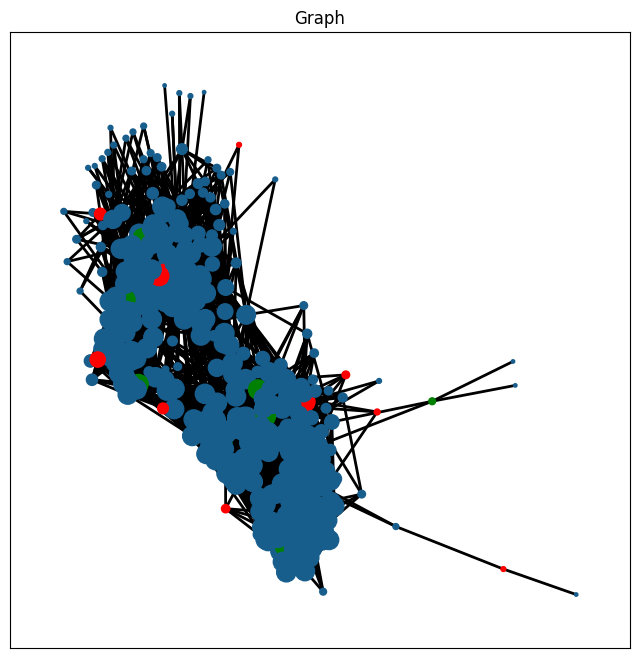

In [20]:
draw_graph(graph_data, source=source, target=target) 

In [25]:
n_iters = cfg.experiment.iterations
all_results = []
for it in range(n_iters):
    print(f"Iteration {it+1}/{n_iters}")
    set_iteration_seed(cfg, it)

    res = run_single_iteration(cfg, it, graph_data, source, target)
    all_results.append(res)

ranking_df, comparison_df, fusion_df = post_process(all_results)

Iteration 1/2


Computing transition probabilities:   0%|          | 0/377 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00, 89.40it/s]


Iteration 2/2


Computing transition probabilities:   0%|          | 0/377 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00, 89.44it/s]


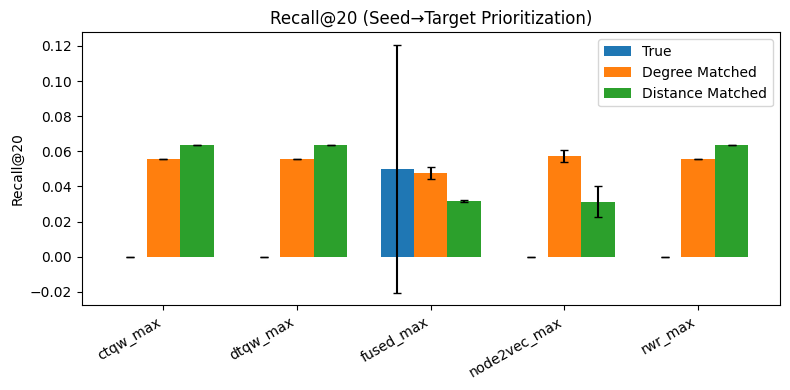

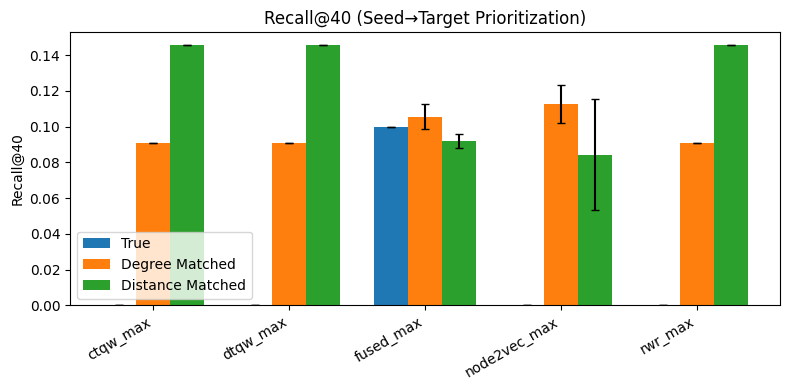

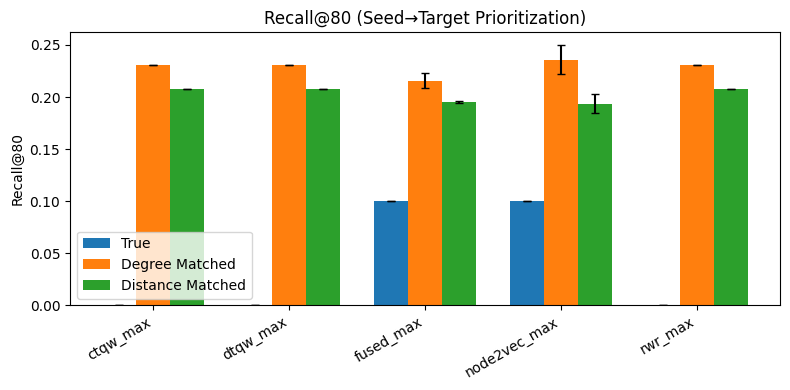

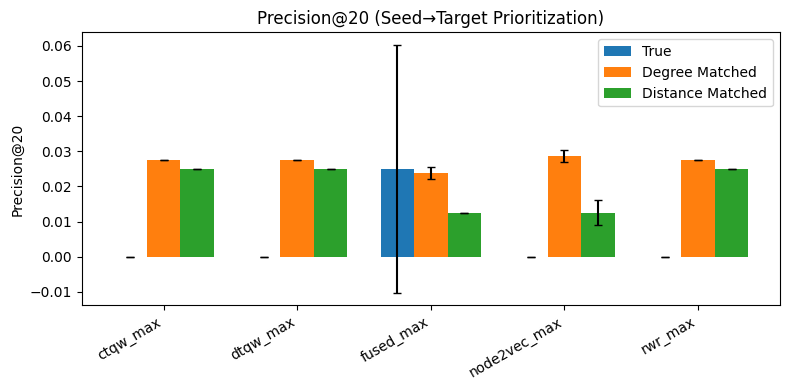

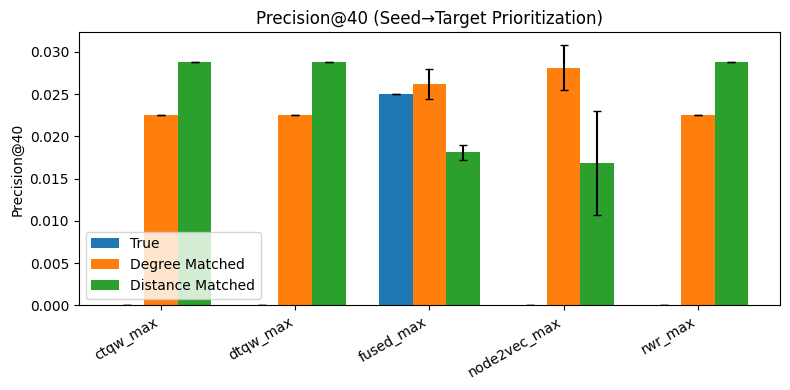

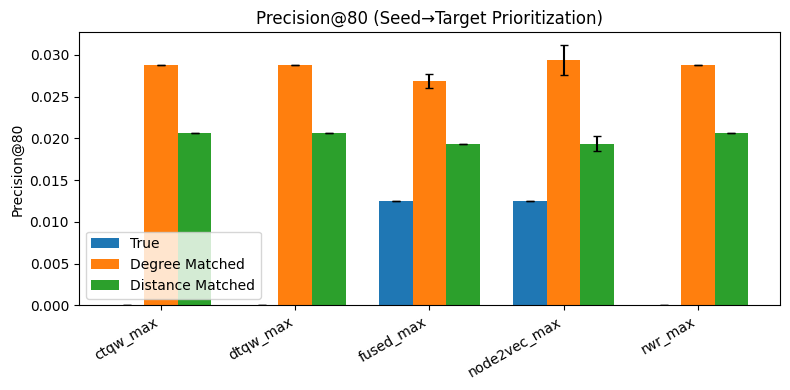

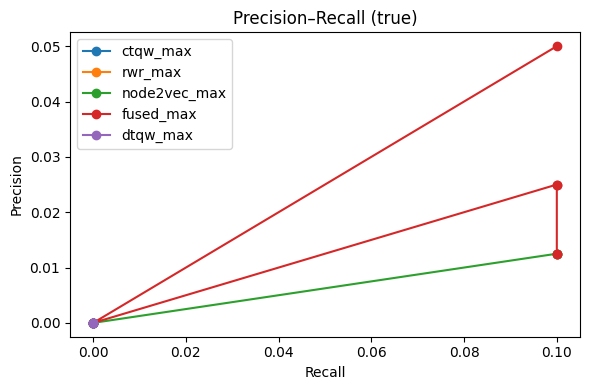

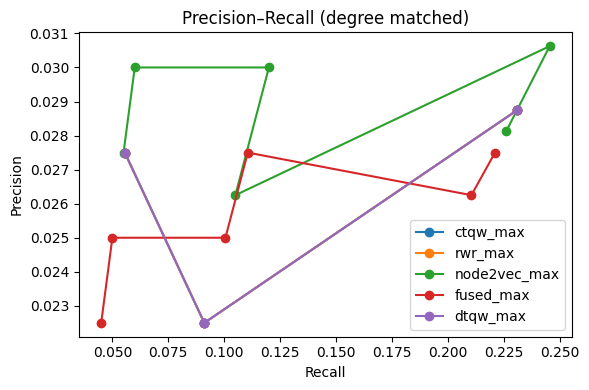

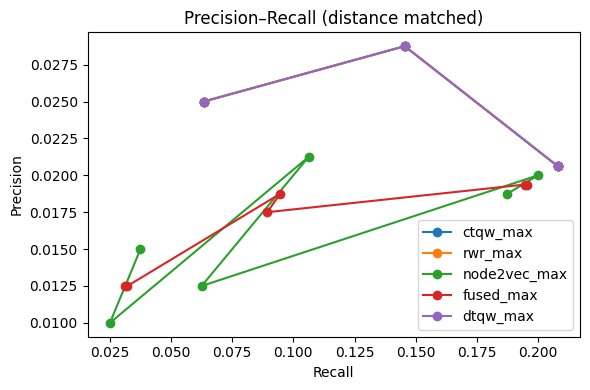

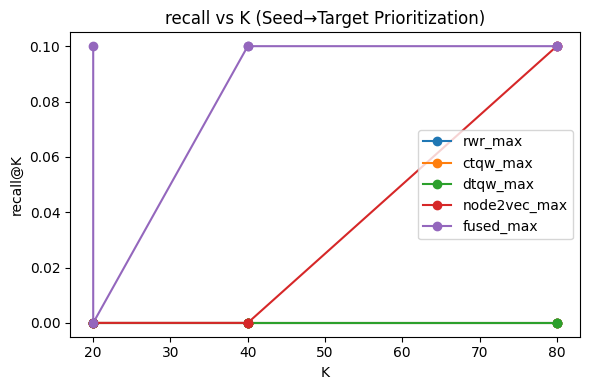

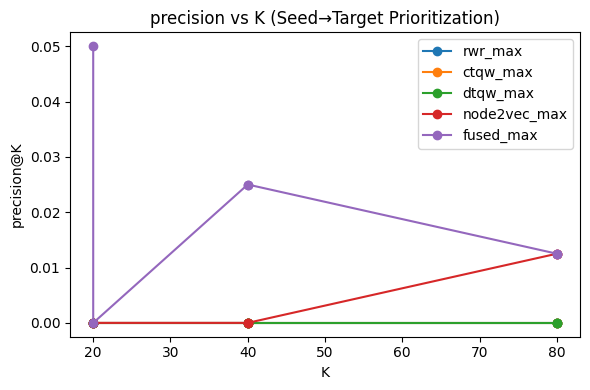

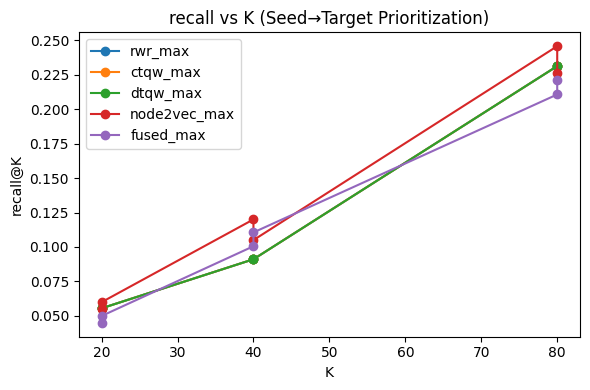

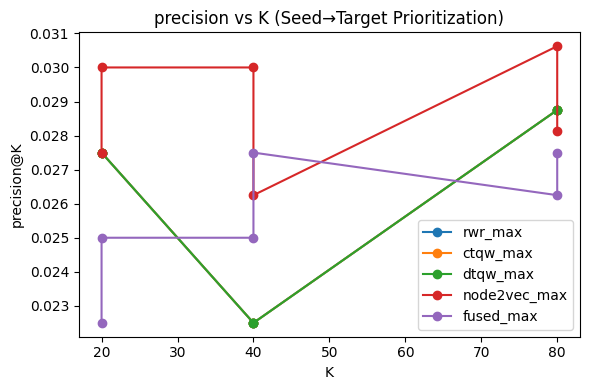

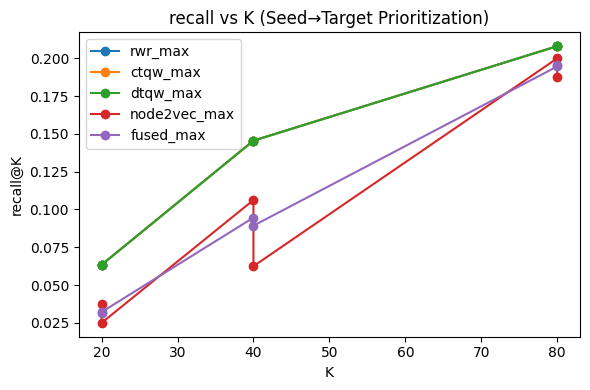

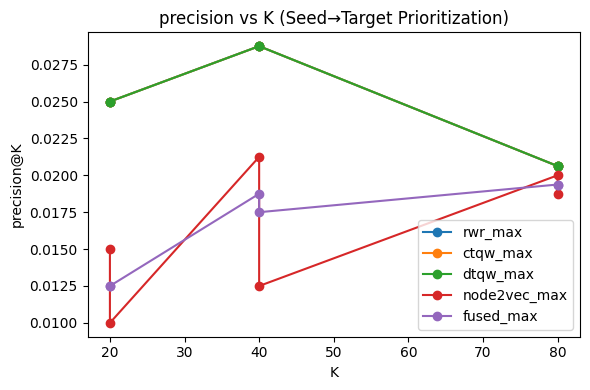

In [32]:
plot_all(cfg, ranking_df, out_dir=cfg.runtime.run_dir)